<h1>Twitter Analysis</h1>

Importing Libraries

In [1]:
# For Data and String Manipulation
import re
import numpy as np
import pandas as pd
import string

# For Plotting and Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For Vectorization and Parameter Tuning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Machine Learning Model
from sklearn.ensemble import RandomForestClassifier

# For Evaluation Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,\
    confusion_matrix,roc_curve,classification_report

In [2]:
data = pd.read_csv('tweet.csv')
data.head()

,sentiment,text
0,sad,agree the poor in india are treated badly thei...
1,joy,if only i could have spent the with this cutie...
2,joy,will nature conservation remain a priority in ...
3,sad,coronavirus disappearing in italy show this to...
4,sad,uk records lowest daily virus death toll since...


In [3]:
joyDf = data[data['sentiment']=='joy']
sadDf = data[data['sentiment']=='sad']
fearDf = data[data['sentiment']=='fear']
angerDf = data[data['sentiment']=='anger']

In [4]:
len = int((joyDf.shape[0])/3)
posDf = joyDf
posDf['sentiment'] = 'positive'
negDf = pd.concat([sadDf.sample(len),fearDf.sample(len),angerDf.sample(len)],axis=0)
negDf['sentiment'] = 'negative'

C:\Users\manav\AppData\Local\Temp\ipykernel_32220\993531512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posDf['sentiment'] = 'positive'


In [5]:
data = pd.concat([posDf,negDf],axis=0)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

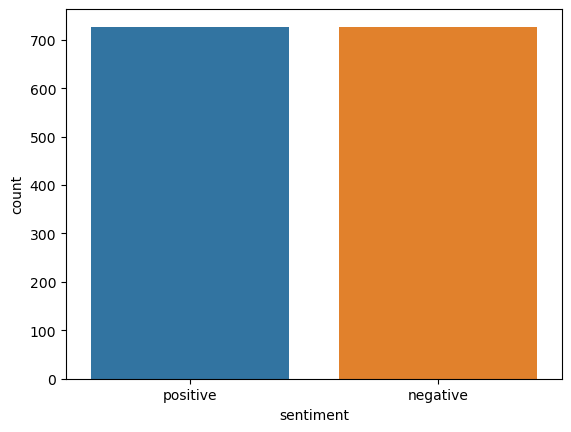

In [6]:
sns.countplot(data=data,x=data['sentiment'])

<p> The dataset has nearly same amount of Class Data Objects. </p>

In [7]:
# Functions for cleaning texts
def remove_emoji(text):
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

def clean_text(text):
        text = re.sub('\[.*?\]','',str(text))
        text = re.sub('https?://\S+|www\.\S+', '',text)
        text = re.sub('<.*?>+','',text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        text = text.lower()
        text = remove_emoji(text)
        return text
     

In [8]:
data['text'] = [clean_text(text) for text in data['text']]

lm = WordNetLemmatizer()

def textTransformer(dataset):
        corpus = []
        for text in dataset:
                text = re.sub('[^a-zA-Z]',' ',text)
                text = text.lower()
                text = text.split()
                text = [lm.lemmatize(word) for word in text if word not in set(stopwords.words('english'))]
                corpus.append(" ".join(text))
        return corpus

data['text'] = textTransformer(data['text'])

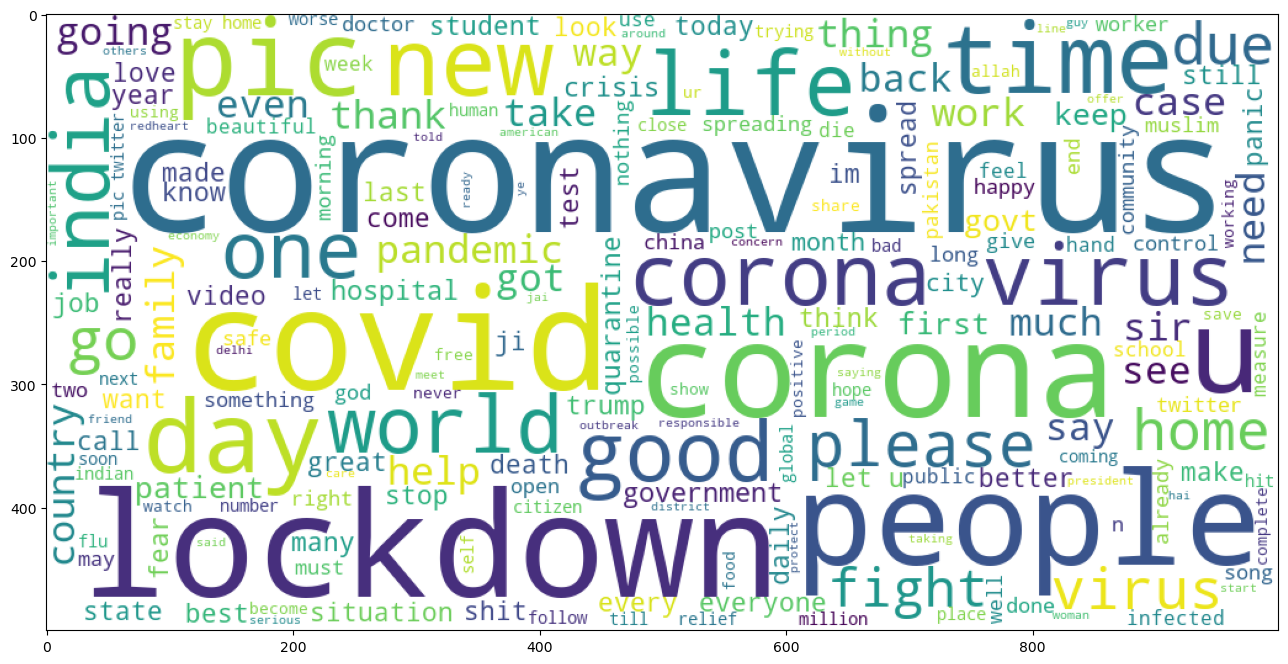

In [9]:
from wordcloud import WordCloud

plt.figure(figsize=(20,8))
word_cloud = ""
for row in data['text']:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [10]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['sentiment'])
train_x, test_x, train_y, test_y = train_test_split(list(data['text']),list(data['label']),test_size=0.33,random_state=42,stratify=list(data['label']))

### Vectorization

In [11]:
vectorizer = CountVectorizer(ngram_range=(1,2))

train_x_vector = vectorizer.fit_transform(train_x)

In [17]:
parameter = {'max_features': 'sqrt',
 'n_estimators': 1000,
 'max_depth': None,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'bootstrap': False}

rfc = RandomForestClassifier(max_features = 'sqrt', n_estimators = 1000,max_depth = None,min_samples_split=5,min_samples_leaf=2,bootstrap=False)
rfc.fit(train_x_vector,train_y)
test_x_vector = vectorizer.transform(test_x)
ypred = rfc.predict(test_x_vector)

In [18]:

acc_score = accuracy_score(test_y,rfc.predict(test_x_vector))
pre_score = precision_score(test_y,rfc.predict(test_x_vector),average='weighted')
rec_score = recall_score(test_y,rfc.predict(test_x_vector),average='weighted')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_y,rfc.predict(test_x_vector))
print(cr)

Accuracy_score:  0.8333333333333334
Precision_score:  0.8333564830891034
Recall_score:  0.8333333333333334
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       240
           1       0.83      0.84      0.83       240

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480



In [14]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()
clf_gnb.fit(train_x_vector.toarray(),train_y)
clf_gnb.predict(test_x_vector[0].toarray())
clf_gnb.score(test_x_vector.toarray(),test_y)

acc_score = accuracy_score(test_y,clf_gnb.predict(test_x_vector.toarray()))
pre_score = precision_score(test_y,clf_gnb.predict(test_x_vector.toarray()),average='weighted')
rec_score = recall_score(test_y,clf_gnb.predict(test_x_vector.toarray()),average='weighted')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_y,clf_gnb.predict(test_x_vector.toarray()))
print(cr)

Accuracy_score:  0.7645833333333333
Precision_score:  0.76495592760653
Recall_score:  0.7645833333333333
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       240
           1       0.76      0.78      0.77       240

    accuracy                           0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.76      0.76      0.76       480



In [15]:
from sklearn import svm
clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vector, train_y)

acc_score = accuracy_score(test_y,clf_svm.predict(test_x_vector))
pre_score = precision_score(test_y,clf_svm.predict(test_x_vector),average='weighted')
rec_score = recall_score(test_y,clf_svm.predict(test_x_vector),average='weighted')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_y,clf_svm.predict(test_x_vector))
print(cr)

Accuracy_score:  0.83125
Precision_score:  0.835496122804241
Recall_score:  0.83125
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       240
           1       0.80      0.89      0.84       240

    accuracy                           0.83       480
   macro avg       0.84      0.83      0.83       480
weighted avg       0.84      0.83      0.83       480



In [16]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(train_x_vector,train_y)

acc_score = accuracy_score(test_y,clf_log.predict(test_x_vector))
pre_score = precision_score(test_y,clf_log.predict(test_x_vector),average='weighted')
rec_score = recall_score(test_y,clf_log.predict(test_x_vector),average='weighted')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(test_y,clf_log.predict(test_x_vector))
print(cr)

Accuracy_score:  0.8416666666666667
Precision_score:  0.8457241233925937
Recall_score:  0.8416666666666667
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       240
           1       0.81      0.90      0.85       240

    accuracy                           0.84       480
   macro avg       0.85      0.84      0.84       480
weighted avg       0.85      0.84      0.84       480



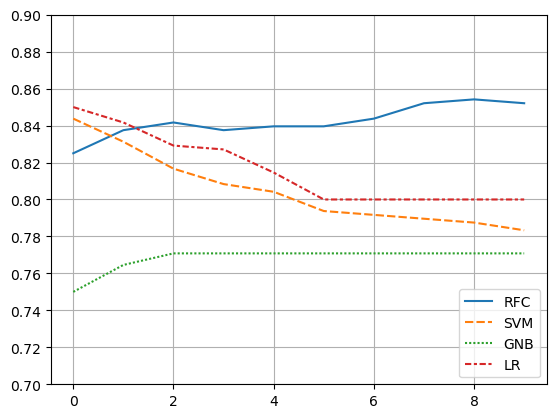

In [34]:
svmAcc = [] 
lrAcc = []
rcfAcc = []
gnbAcc = []

for i in range(1,11):
    vectorizer = CountVectorizer(ngram_range=(1,i))

    train_x_vector = vectorizer.fit_transform(train_x)
    test_x_vector = vectorizer.transform(test_x)
    
    rfc = RandomForestClassifier(max_features = 'sqrt', n_estimators = 1000,max_depth = None,min_samples_split=5,min_samples_leaf=2,bootstrap=False)

    rfc.fit(train_x_vector,train_y)
    
    clf_log = LogisticRegression()
    clf_log.fit(train_x_vector,train_y)
    
    clf_svm = svm.SVC(kernel='linear')
    clf_svm.fit(train_x_vector, train_y)
    
    clf_gnb = GaussianNB()
    clf_gnb.fit(train_x_vector.toarray(),train_y)
    
    svmAcc.append(accuracy_score(test_y,clf_svm.predict(test_x_vector)))
    rcfAcc.append(accuracy_score(test_y,rfc.predict(test_x_vector)))
    lrAcc.append(accuracy_score(test_y,clf_log.predict(test_x_vector)))
    gnbAcc.append(accuracy_score(test_y,clf_gnb.predict(test_x_vector.toarray())))
    



    

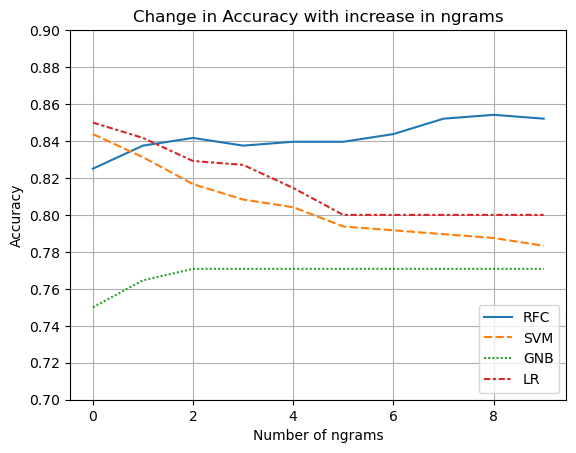

In [35]:
AccRes = pd.DataFrame({'RFC':rcfAcc, 'SVM':svmAcc, 'GNB':gnbAcc, 'LR':lrAcc})
sns.lineplot(data=AccRes)
plt.yticks(np.arange(0.7,0.9,0.02,dtype=float))
plt.grid('on')
plt.title('Change in Accuracy with increase in ngrams')
plt.xlabel('Number of ngrams')
plt.ylabel('Accuracy')
plt.show()

\section{Technologies Used}
\subsection{NLTK}
We can use the Python library NLTK, or Natural Language Toolkit, for NLP. A large portion of the data that you might be analysing is unstructured and contains text that can be read by humans. Preprocessing that data is necessary before you can programmatically analyse it. NLTK offers us numerous test datasets and different text processing libraries. For tokenization, parsing, classification, stemming, tagging, and semantic reasoning, it includes text processing libraries. Additionally, there are graphical examples included.Steven Bird, Edward Loper, and Ewan Klein created the Natural Language Toolkit as an open source library for the Python programming language with the intention of using it for development and education.More than 50 corpora and lexical sources, including the Open Multilingual Wordnet, the Penn Treebank Corpus, and Problem Report Corpus, and Lin’s Dependency Thesaurus.

\subsection{Scikit Learn}
One of the most effective and reliable Python machine learning library is called Skearn (Skit-Learn). Through a Python consistency interface, it offers a variety of effective methods for statistical modelling and machine learning, including classification, regression, clustering, and dimensionality reduction. This library is based on NumPy, SciPy, and Matplotlib and was written primarily in Python.It supports Python's scientific and numerical libraries, and it includes a variety of algorithms like the support vector machine, random forests, and k-neighbors etc.

\subsection{Count Vectorizer}
Text must be tokenized, or parsed to eliminate specific words, in order to use textual data for predictive modelling. Characters and words are not understood by machines. So, in order for a machine to understand text data, it must be represented in numerical form. Then, in order to be used as inputs in machine learning algorithms, these words must be encoded as integers or floating-point numbers. The vectorization of features is the method in question.

A collection of text documents is transformed into a vector of term/token counts using Scikit-learn's CountVectorizer. Additionally, it makes it possible to pre-process text data before creating the vector representation. It is a very flexible feature representation module for text because of this functionality.

